## Shortest Paths and OpenStreetMap Data  
### OSM file method, PBF to XML format

This implementation takes the following approach:
* Download OpenStreetMap data from Geofabrik, a third party OSM data provider. Data is downloaded in PBF format.
* Convert data into XML format using Osmosis.
* Convert XML data into a NetworkX graph object with the get_osm_data module.
* Use a shortest path algorithm already implemented in NetworkX to find the shortest path between two nodes.

References:
* Osmosis https://wiki.openstreetmap.org/wiki/Osmosis.

Conclusions:
* This is a reasonable method to obtain OpenStreetMap data, although it's somewhat cumbersome in that it requires manual command line processing of the downloaded data.

In [1]:
import get_osm_data
import networkx as nx
from haversine import haversine

import pandas as pd

import matplotlib.pyplot as plt
%pylab inline

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


### Convert PBF to XML
Use Osmosis (on the command line) to convert the PBF format files to XML. An example for the state of Delaware is shown below.

### Generate a NetworkX graph object from the XML file.

In [2]:
map_file = '/Users/jason/code/msan694/osm_data/delaware.osm'

In [3]:
G = get_osm_data.read_osm(map_file)

### Take a look at the graph

In [4]:
# Basic info about the graph:
G.number_of_nodes(), G.number_of_edges()

(352611, 704507)

Nodes are represented as unicode strings.

In [5]:
G.nodes(data=True)[0]

(u'178607729', {'lat': 39.002645, 'lon': -75.378781})

In [6]:
G.edges(data=True)[0]

(u'178607729',
 u'178607727',
 {'highway': u'residential',
  'id': u'17216150-1',
  'name': u'Bennetts Pier Road'})

### Assign edge weights
Assign a weight to every edge in the graph. This is probably a really inefficient way of assigning edge weights. A better way might be to assign a weight only if the edge is examined in a shortest paths algorithm.

In [7]:
def calc_distance(node0, node1):
    # Return distance between two nodes in meters
    lat0 = node0['lat']
    lon0 = node0['lon']
    lat1 = node1['lat']
    lon1 = node1['lon']
    return 1000* haversine((lat0, lon0), (lat1, lon1), miles = False)    

In [8]:
for node0, node1 in G.edges_iter():
    G[node0][node1]['distance'] = calc_distance(G.node[node0], G.node[node1])

### Export edge list to CSV (for processing in Spark or Hive)

In [9]:
def process_edgelist(edge):
    return (edge[0], edge[1], edge[2]['distance'])

In [10]:
edgelist = map(process_edgelist, nx.to_edgelist(G))

In [11]:
edgelist_df = pd.DataFrame.from_records(edgelist, columns=['node0', 'node1', 'distance'])
edgelist_df.to_csv('edgelist.csv.gz', header=False, index=False, compression='gzip')

### Plot the graph, using latitude and longitude as x and y coordinates.

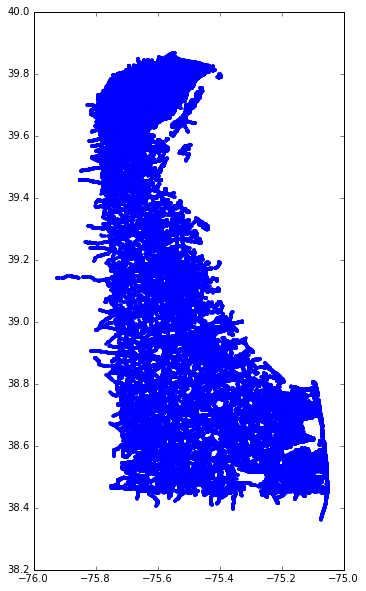

In [9]:
# Longitude is an East-West coordinate
# Latitude is North-South coordinate
fig = plt.figure(figsize=(10, 10))  # a new figure window
ax = fig.add_subplot(1, 1, 1)  # specify (nrows, ncols, axnum)
ax.plot([G.node[n]['lon'] for n in G], [G.node[n]['lat'] for n in G], '.')
ax.set_aspect(aspect='equal')

### Find a shortest path

In [10]:
# Sample nodes from the Delaware map:
start_node = '178641055'
end_node = '178718777'

ends = (start_node, end_node)

In [11]:
path = nx.dijkstra_path(G, start_node, end_node, weight='distance')

In [12]:
path_length = nx.dijkstra_path_length(G, start_node, end_node, weight='distance')
path_length

157131.87123125835

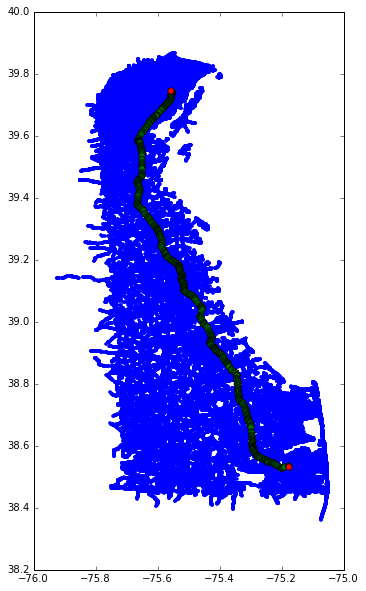

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot([G.node[n]['lon'] for n in G], [G.node[n]['lat'] for n in G], '.')
ax.plot([G.node[n]['lon'] for n in path], [G.node[n]['lat'] for n in path], 'o')
ax.plot([G.node[n]['lon'] for n in ends], [G.node[n]['lat'] for n in ends], 'o')
ax.set_aspect(aspect='equal')